## 实验方法
固定总的训练周期数量（Epoch）为10，比较如下不同的训练方式：
- 先用0～4这5个数字训练卷积网络ConvNet，再用后面的5～9这五个数字训练ConvNet；(half_half)
- 先用0～4这5个数字训练卷积网络ConvNet，然后再用0～9全部十个数字来训练ConvNet；(half_all)
- 直接用0～9这十个数字训练ConvNet.(all)
### 细节设计
1. 0-4 训练集和 5-9 训练集大小设置为25000，0-9训练集大小设置为25000
2. half_half 和 half_all 实验中两次训练的 epoch 分别为总 epoch 的一半
3. 实验结果存入 results 中，包括训练集 loss (平均)，校验集 loss (平均)，校验集准确率和测试集准确率

In [104]:
# 导入所需要的包
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [105]:
# 训练和测试数据集
train_dataset = dsets.MNIST(root='./data',  
                            train=True,   
                            transform=transforms.ToTensor(),  
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [106]:
# Hyper Parameters 
image_size = 28  
num_classes = 10  
num_epochs = 10  #训练的总循环周期
batch_size = 64
learning_rate = 0.001

In [107]:
# 训练数据三种采样器下标，每个采样器大小都为25000
Indices_train1 = []
Indices_train2 = []
for i in range(len(train_dataset)):
    data,target = train_dataset[i]
    if target <= 4:
        Indices_train1.append(i)
for j in range(len(train_dataset)):
    data,target = train_dataset[j]
    if target > 4:
        Indices_train2.append(j)
Indices_train1 = np.random.permutation(Indices_train1)[:25000] 
Indices_train2 = np.random.permutation(Indices_train2)[:25000]
Indices_train = np.random.permutation(range(len(train_dataset)))[:25000]

In [108]:
# 训练集数据采样器和加载器
sampler_train1 = torch.utils.data.sampler.SubsetRandomSampler(Indices_train1)
sampler_train2 = torch.utils.data.sampler.SubsetRandomSampler(Indices_train2)
sampler_train = torch.utils.data.sampler.SubsetRandomSampler(Indices_train)
train_loader1 = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          sampler = sampler_train1
                                         )
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          sampler = sampler_train2
                                         )
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          sampler = sampler_train
                                         )

In [109]:
# 测试数据集的加载器，自动将数据分割成batch
permutes = np.random.permutation(range(len(test_dataset)))
indices_val = permutes[:5000]
indices_test = permutes[5000:]
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)
validation_loader = torch.utils.data.DataLoader(dataset =train_dataset,
                                                batch_size = batch_size,
                                                shuffle = False,
                                                sampler = sampler_val
                                               )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          sampler = sampler_test
                                         )

In [110]:
#定义卷积神经网络：4和8为人为指定的两个卷积层的厚度
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, padding = 2) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) 
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1] , 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        #神经网络完成一步前馈运算的过程，从输入到输出
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)        
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x)) 
        x = F.dropout(x, training=self.training) 
        x = self.fc2(x) 
        x = F.log_softmax(x) 
        return x

In [111]:
# 定义准确率函数
def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1] 
    rights = pred.eq(labels.data.view_as(pred)).sum() 
    return rights, len(labels) 

In [112]:
results = {}
times = 5
# 开始实验1
experiment = 'half_half'
for time in range(times):
    net = ConvNet() 
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
    record = [] 

    #开始训练循环
    for epoch in range(int(num_epochs / 2)):
        losses = []
        train_rights = [] 
        for batch_idx, (data, target) in enumerate(train_loader1): 
            data, target = Variable(data), Variable(target) 
            net.train() 
            output = net(data) 
            loss = criterion(output, target) 
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
            right = rightness(output, target) 
            train_rights.append(right) 
            losses.append(loss.data.numpy())


            if batch_idx % 100 == 0: 
                train_r = 1.0 * np.sum([i[0] for i in train_rights]) / np.sum([i[1] for i in train_rights])
                net.eval() 
                val_rights = [] 
                val_losses = []
                for (data, target) in validation_loader:
                    data, target = Variable(data), Variable(target)
                    output = net(data) 
                    right = rightness(output, target) 
                    val_rights.append(right)
                    val_losses.append(loss.data.numpy())
                val_r = 1.0 * np.sum([i[0] for i in val_rights]) / np.sum([i[1] for i in val_rights])
                record.append([np.mean(losses), np.mean(val_losses), val_r])            
                print('{}实验 \t第{}次 \t训练周期:{} {}/{} \t训练误差: {:.6f} \t校验误差: {:.6f} \t训练正确率: {:.2f}\t校验正确率: {:.2f}'.format(
                    experiment, time, epoch, batch_idx, len(train_loader1),
                    np.mean(losses), np.mean(val_losses), train_r, val_r))

    for epoch in range(int(num_epochs/2 + 1),num_epochs):
        train_rights = []
        losses = []
        for batch_idx, (data, target) in enumerate(train_loader2):  
            data, target = Variable(data), Variable(target) 
            net.train() 
            output = net(data) 
            loss = criterion(output, target) 
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
            right = rightness(output, target) 
            train_rights.append(right)
            losses.append(loss.data.numpy())

            if batch_idx % 100 == 0: 
                train_r = 1.0 * np.sum([i[0] for i in train_rights]) / np.sum([i[1] for i in train_rights])
                net.eval() 
                val_rights = [] 
                val_losses = []
                for (data, target) in validation_loader:
                    data, target = Variable(data), Variable(target)
                    output = net(data) 
                    right = rightness(output, target)
                    val_rights.append(right)
                    val_losses.append(loss.data.numpy())
                val_r = 1.0 * np.sum([i[0] for i in val_rights]) / np.sum([i[1] for i in val_rights])                  
                record.append([np.mean(losses), np.mean(val_losses), val_r])
                print('{}实验 \t第{}次 \t训练周期:{} {}/{} \t训练误差: {:.6f} \t校验误差: {:.6f} \t训练正确率: {:.2f}\t校验正确率: {:.2f}'.format(
                    experiment, time, epoch, batch_idx, len(train_loader2),
                    np.mean(losses), np.mean(val_losses), train_r, val_r))
    net.eval() 
    test_rights = [] 
    test_losses = []
    for (data, target) in test_loader:
        data, target = Variable(data), Variable(target)
        output = net(data) 
        right = rightness(output, target) 
        test_rights.append(right)
        test_losses.append(loss.data.numpy())
    right_ratio = 1.0 * np.sum([i[0] for i in test_rights]) / np.sum([i[1] for i in test_rights])
    results[(experiment,time)] = [record, right_ratio]  

half_half实验 	第0次 	训练周期:0 0/391 	训练误差: 2.296699 	校验误差: 2.296698 	训练正确率: 0.11	校验正确率: 0.11
half_half实验 	第0次 	训练周期:0 100/391 	训练误差: 1.920490 	校验误差: 1.530790 	训练正确率: 0.24	校验正确率: 0.30
half_half实验 	第0次 	训练周期:0 200/391 	训练误差: 1.569984 	校验误差: 0.708211 	训练正确率: 0.41	校验正确率: 0.44
half_half实验 	第0次 	训练周期:0 300/391 	训练误差: 1.205257 	校验误差: 0.436537 	训练正确率: 0.56	校验正确率: 0.46
half_half实验 	第0次 	训练周期:1 0/391 	训练误差: 0.122517 	校验误差: 0.122517 	训练正确率: 0.97	校验正确率: 0.47
half_half实验 	第0次 	训练周期:1 100/391 	训练误差: 0.224164 	校验误差: 0.336937 	训练正确率: 0.93	校验正确率: 0.48
half_half实验 	第0次 	训练周期:1 200/391 	训练误差: 0.209475 	校验误差: 0.170610 	训练正确率: 0.94	校验正确率: 0.48
half_half实验 	第0次 	训练周期:1 300/391 	训练误差: 0.195760 	校验误差: 0.079709 	训练正确率: 0.94	校验正确率: 0.48
half_half实验 	第0次 	训练周期:2 0/391 	训练误差: 0.096430 	校验误差: 0.096429 	训练正确率: 0.95	校验正确率: 0.48
half_half实验 	第0次 	训练周期:2 100/391 	训练误差: 0.146502 	校验误差: 0.038752 	训练正确率: 0.96	校验正确率: 0.49
half_half实验 	第0次 	训练周期:2 200/391 	训练误差: 0.141478 	校验误差: 0.145353 	训练正确率: 0.96	校验正确率: 0.49
half_half实验 	第0次

half_half实验 	第2次 	训练周期:6 0/391 	训练误差: 10.614622 	校验误差: 10.614623 	训练正确率: 0.00	校验正确率: 0.49
half_half实验 	第2次 	训练周期:6 100/391 	训练误差: 1.383293 	校验误差: 0.559268 	训练正确率: 0.56	校验正确率: 0.42
half_half实验 	第2次 	训练周期:6 200/391 	训练误差: 0.955034 	校验误差: 0.417471 	训练正确率: 0.69	校验正确率: 0.44
half_half实验 	第2次 	训练周期:6 300/391 	训练误差: 0.771235 	校验误差: 0.269867 	训练正确率: 0.75	校验正确率: 0.44
half_half实验 	第2次 	训练周期:7 0/391 	训练误差: 0.329701 	校验误差: 0.329702 	训练正确率: 0.89	校验正确率: 0.45
half_half实验 	第2次 	训练周期:7 100/391 	训练误差: 0.321847 	校验误差: 0.294077 	训练正确率: 0.89	校验正确率: 0.45
half_half实验 	第2次 	训练周期:7 200/391 	训练误差: 0.301063 	校验误差: 0.172487 	训练正确率: 0.90	校验正确率: 0.46
half_half实验 	第2次 	训练周期:7 300/391 	训练误差: 0.284742 	校验误差: 0.322341 	训练正确率: 0.90	校验正确率: 0.46
half_half实验 	第2次 	训练周期:8 0/391 	训练误差: 0.257917 	校验误差: 0.257917 	训练正确率: 0.89	校验正确率: 0.46
half_half实验 	第2次 	训练周期:8 100/391 	训练误差: 0.214608 	校验误差: 0.110831 	训练正确率: 0.93	校验正确率: 0.47
half_half实验 	第2次 	训练周期:8 200/391 	训练误差: 0.214817 	校验误差: 0.155772 	训练正确率: 0.93	校验正确率: 0.47
half_half实验 	第

In [113]:
# 开始实验2
experiment = 'half_all'
for time in range(times):
    net = ConvNet() 
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
    record = [] 
    #开始训练循环
    for epoch in range(int(num_epochs / 2)):
        losses = []
        train_rights = [] 
        for batch_idx, (data, target) in enumerate(train_loader1): 
            data, target = Variable(data), Variable(target) 
            net.train()
            output = net(data) 
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
            right = rightness(output, target) 
            train_rights.append(right) 
            losses.append(loss.data.numpy())


            if batch_idx % 100 == 0:
                train_r = 1.0 * np.sum([i[0] for i in train_rights]) / np.sum([i[1] for i in train_rights])
                net.eval() # 校验集上测试
                val_rights = [] 
                val_losses = []
                for (data, target) in validation_loader:
                    data, target = Variable(data), Variable(target)
                    output = net(data) 
                    right = rightness(output, target) 
                    val_rights.append(right)
                    val_losses.append(loss.data.numpy())
                val_r = 1.0 * np.sum([i[0] for i in val_rights]) / np.sum([i[1] for i in val_rights])
                record.append([np.mean(losses), np.mean(val_losses), val_r])            
                print('{}实验 \t第{}次 \t训练周期:{} {}/{} \t训练误差: {:.6f} \t校验误差: {:.6f} \t训练正确率: {:.2f}\t校验正确率: {:.2f}'.format(
                    experiment, time, epoch, batch_idx, len(train_loader1),
                    np.mean(losses), np.mean(val_losses), train_r, val_r))

    for epoch in range(int(num_epochs/2 + 1),num_epochs):
        train_rights = []
        losses = []
        for batch_idx, (data, target) in enumerate(train_loader):  
            data, target = Variable(data), Variable(target)
            net.train() 
            output = net(data) 
            loss = criterion(output, target) 
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
            right = rightness(output, target)
            train_rights.append(right) 
            losses.append(loss.data.numpy())

            if batch_idx % 100 == 0: 
                train_r = 1.0 * np.sum([i[0] for i in train_rights]) / np.sum([i[1] for i in train_rights])
                net.eval() 
                val_rights = [] 
                val_losses = []
                for (data, target) in validation_loader:
                    data, target = Variable(data), Variable(target)
                    output = net(data) 
                    right = rightness(output, target) 
                    val_rights.append(right)
                    val_losses.append(loss.data.numpy())
                val_r = 1.0 * np.sum([i[0] for i in val_rights]) / np.sum([i[1] for i in val_rights])       
                record.append([np.mean(losses), np.mean(val_losses), val_r])
                print('{}实验 \t第{}次 \t训练周期:{} {}/{} \t训练误差: {:.6f} \t校验误差: {:.6f} \t训练正确率: {:.2f}\t校验正确率: {:.2f}'.format(
                    experiment, time, epoch, batch_idx, len(train_loader),
                    np.mean(losses), np.mean(val_losses), train_r, val_r))
    net.eval() # 测试集上测试
    test_rights = [] 
    test_losses = []
    for (data, target) in test_loader:
        data, target = Variable(data), Variable(target)
        output = net(data) 
        right = rightness(output, target) 
        test_rights.append(right)
        test_losses.append(loss.data.numpy())
    right_ratio = 1.0 * np.sum([i[0] for i in test_rights]) / np.sum([i[1] for i in test_rights])
    results[(experiment,time)] = [record, right_ratio]  

half_all实验 	第0次 	训练周期:0 0/391 	训练误差: 2.296002 	校验误差: 2.296002 	训练正确率: 0.05	校验正确率: 0.11
half_all实验 	第0次 	训练周期:0 100/391 	训练误差: 2.142045 	校验误差: 1.813465 	训练正确率: 0.23	校验正确率: 0.22
half_all实验 	第0次 	训练周期:0 200/391 	训练误差: 1.832251 	校验误差: 1.231331 	训练正确率: 0.31	校验正确率: 0.43
half_all实验 	第0次 	训练周期:0 300/391 	训练误差: 1.481800 	校验误差: 0.418889 	训练正确率: 0.46	校验正确率: 0.46
half_all实验 	第0次 	训练周期:1 0/391 	训练误差: 0.260728 	校验误差: 0.260728 	训练正确率: 0.89	校验正确率: 0.47
half_all实验 	第0次 	训练周期:1 100/391 	训练误差: 0.226169 	校验误差: 0.395344 	训练正确率: 0.93	校验正确率: 0.48
half_all实验 	第0次 	训练周期:1 200/391 	训练误差: 0.212184 	校验误差: 0.185080 	训练正确率: 0.93	校验正确率: 0.48
half_all实验 	第0次 	训练周期:1 300/391 	训练误差: 0.201435 	校验误差: 0.300586 	训练正确率: 0.94	校验正确率: 0.48
half_all实验 	第0次 	训练周期:2 0/391 	训练误差: 0.125058 	校验误差: 0.125058 	训练正确率: 0.97	校验正确率: 0.48
half_all实验 	第0次 	训练周期:2 100/391 	训练误差: 0.148922 	校验误差: 0.088775 	训练正确率: 0.95	校验正确率: 0.49
half_all实验 	第0次 	训练周期:2 200/391 	训练误差: 0.146683 	校验误差: 0.147758 	训练正确率: 0.96	校验正确率: 0.49
half_all实验 	第0次 	训练周期:2 300

half_all实验 	第2次 	训练周期:6 100/391 	训练误差: 1.108644 	校验误差: 0.440870 	训练正确率: 0.68	校验正确率: 0.84
half_all实验 	第2次 	训练周期:6 200/391 	训练误差: 0.853416 	校验误差: 0.440723 	训练正确率: 0.74	校验正确率: 0.87
half_all实验 	第2次 	训练周期:6 300/391 	训练误差: 0.732587 	校验误差: 0.461829 	训练正确率: 0.78	校验正确率: 0.88
half_all实验 	第2次 	训练周期:7 0/391 	训练误差: 0.598022 	校验误差: 0.598022 	训练正确率: 0.78	校验正确率: 0.91
half_all实验 	第2次 	训练周期:7 100/391 	训练误差: 0.396241 	校验误差: 0.400720 	训练正确率: 0.87	校验正确率: 0.91
half_all实验 	第2次 	训练周期:7 200/391 	训练误差: 0.379480 	校验误差: 0.223394 	训练正确率: 0.88	校验正确率: 0.91
half_all实验 	第2次 	训练周期:7 300/391 	训练误差: 0.367499 	校验误差: 0.201583 	训练正确率: 0.88	校验正确率: 0.92
half_all实验 	第2次 	训练周期:8 0/391 	训练误差: 0.359207 	校验误差: 0.359207 	训练正确率: 0.89	校验正确率: 0.92
half_all实验 	第2次 	训练周期:8 100/391 	训练误差: 0.299584 	校验误差: 0.223882 	训练正确率: 0.90	校验正确率: 0.93
half_all实验 	第2次 	训练周期:8 200/391 	训练误差: 0.294662 	校验误差: 0.357295 	训练正确率: 0.91	校验正确率: 0.93
half_all实验 	第2次 	训练周期:8 300/391 	训练误差: 0.292266 	校验误差: 0.258173 	训练正确率: 0.91	校验正确率: 0.94
half_all实验 	第2次 	训练周期:9 0

In [114]:
# 开始实验3
experiment = 'all'
for time in range(times):
    net = ConvNet() 
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    record = [] 

    #开始训练循环
    for epoch in range(int(num_epochs)):
        losses = []
        train_rights = [] 
        for batch_idx, (data, target) in enumerate(train_loader):  
            data, target = Variable(data), Variable(target) 
            net.train() 
            output = net(data) 
            loss = criterion(output, target)
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 
            right = rightness(output, target) 
            train_rights.append(right) 
            losses.append(loss.data.numpy())


            if batch_idx % 100 == 0: 
                train_r = 1.0 * np.sum([i[0] for i in train_rights]) / np.sum([i[1] for i in train_rights])
                net.eval()
                val_rights = [] 
                val_losses = []
                for (data, target) in validation_loader:
                    data, target = Variable(data), Variable(target)
                    output = net(data)
                    right = rightness(output, target) 
                    val_rights.append(right)
                    val_losses.append(loss.data.numpy())
                val_r = 1.0 * np.sum([i[0] for i in val_rights]) / np.sum([i[1] for i in val_rights])
                record.append([np.mean(losses), np.mean(val_losses), val_r])            
                print('{}实验 \t第{}次 \t训练周期:{} {}/{} \t训练误差: {:.6f} \t校验误差: {:.6f} \t训练正确率: {:.2f}\t校验正确率: {:.2f}'.format(
                    experiment, time, epoch, batch_idx, len(train_loader),
                    np.mean(losses), np.mean(val_losses), train_r, val_r))
    net.eval() 
    test_rights = [] 
    test_losses = []
    for (data, target) in test_loader:
        data, target = Variable(data), Variable(target)
        output = net(data) 
        right = rightness(output, target) 
        test_rights.append(right)
        test_losses.append(loss.data.numpy())
    right_ratio = 1.0 * np.sum([i[0] for i in test_rights]) / np.sum([i[1] for i in test_rights])
    results[(experiment,time)] = [record, right_ratio]  

all实验 	第0次 	训练周期:0 0/391 	训练误差: 2.295899 	校验误差: 2.295899 	训练正确率: 0.12	校验正确率: 0.13
all实验 	第0次 	训练周期:0 100/391 	训练误差: 2.295106 	校验误差: 2.286453 	训练正确率: 0.14	校验正确率: 0.20
all实验 	第0次 	训练周期:0 200/391 	训练误差: 2.285955 	校验误差: 2.252656 	训练正确率: 0.18	校验正确率: 0.35
all实验 	第0次 	训练周期:0 300/391 	训练误差: 2.263304 	校验误差: 2.141154 	训练正确率: 0.22	校验正确率: 0.33
all实验 	第0次 	训练周期:1 0/391 	训练误差: 1.625435 	校验误差: 1.625436 	训练正确率: 0.50	校验正确率: 0.68
all实验 	第0次 	训练周期:1 100/391 	训练误差: 1.230956 	校验误差: 0.974961 	训练正确率: 0.66	校验正确率: 0.80
all实验 	第0次 	训练周期:1 200/391 	训练误差: 0.984172 	校验误差: 0.684116 	训练正确率: 0.72	校验正确率: 0.85
all实验 	第0次 	训练周期:1 300/391 	训练误差: 0.852158 	校验误差: 0.661077 	训练正确率: 0.75	校验正确率: 0.87
all实验 	第0次 	训练周期:2 0/391 	训练误差: 0.558360 	校验误差: 0.558360 	训练正确率: 0.81	校验正确率: 0.89
all实验 	第0次 	训练周期:2 100/391 	训练误差: 0.483009 	校验误差: 0.465568 	训练正确率: 0.85	校验正确率: 0.89
all实验 	第0次 	训练周期:2 200/391 	训练误差: 0.448554 	校验误差: 0.288886 	训练正确率: 0.87	校验正确率: 0.90
all实验 	第0次 	训练周期:2 300/391 	训练误差: 0.429144 	校验误差: 0.349862 	训练正确率: 0.87	校验正确率: 0.9

all实验 	第2次 	训练周期:4 300/391 	训练误差: 0.288393 	校验误差: 0.535720 	训练正确率: 0.91	校验正确率: 0.93
all实验 	第2次 	训练周期:5 0/391 	训练误差: 0.209082 	校验误差: 0.209082 	训练正确率: 0.92	校验正确率: 0.93
all实验 	第2次 	训练周期:5 100/391 	训练误差: 0.262217 	校验误差: 0.262962 	训练正确率: 0.92	校验正确率: 0.94
all实验 	第2次 	训练周期:5 200/391 	训练误差: 0.257396 	校验误差: 0.255364 	训练正确率: 0.92	校验正确率: 0.94
all实验 	第2次 	训练周期:5 300/391 	训练误差: 0.243809 	校验误差: 0.415556 	训练正确率: 0.92	校验正确率: 0.94
all实验 	第2次 	训练周期:6 0/391 	训练误差: 0.309433 	校验误差: 0.309433 	训练正确率: 0.89	校验正确率: 0.94
all实验 	第2次 	训练周期:6 100/391 	训练误差: 0.211038 	校验误差: 0.085828 	训练正确率: 0.93	校验正确率: 0.94
all实验 	第2次 	训练周期:6 200/391 	训练误差: 0.219357 	校验误差: 0.171953 	训练正确率: 0.93	校验正确率: 0.95
all实验 	第2次 	训练周期:6 300/391 	训练误差: 0.210314 	校验误差: 0.213167 	训练正确率: 0.94	校验正确率: 0.95
all实验 	第2次 	训练周期:7 0/391 	训练误差: 0.087516 	校验误差: 0.087516 	训练正确率: 0.98	校验正确率: 0.95
all实验 	第2次 	训练周期:7 100/391 	训练误差: 0.185726 	校验误差: 0.423835 	训练正确率: 0.94	校验正确率: 0.95
all实验 	第2次 	训练周期:7 200/391 	训练误差: 0.191244 	校验误差: 0.313404 	训练正确率: 0.94	校验正确率: 0.9

all实验 	第4次 	训练周期:9 200/391 	训练误差: 0.148047 	校验误差: 0.070369 	训练正确率: 0.95	校验正确率: 0.97
all实验 	第4次 	训练周期:9 300/391 	训练误差: 0.143195 	校验误差: 0.150961 	训练正确率: 0.96	校验正确率: 0.97


## 实验结果
分别绘制校验集错误率曲线，训练集和校验集 Loss 曲线，并对比三种情况下测试集上分类准确度

In [115]:
# 绘制校验集测试错误率曲线
one_curve = {}
tests = {}
for experiment in ['all', 'half_all', 'half_half']:
    one_experiment = []
    test_value = []
    for time in range(times):
        rr = results[(experiment, time)]
        one_experiment.append([ii[2] for ii in rr[0]])
        test_value.append(rr[1])
    aa = np.array(one_experiment)
    one_curve[(experiment)] = np.mean(aa, 0)
    tests[(experiment)] = np.mean(test_value)

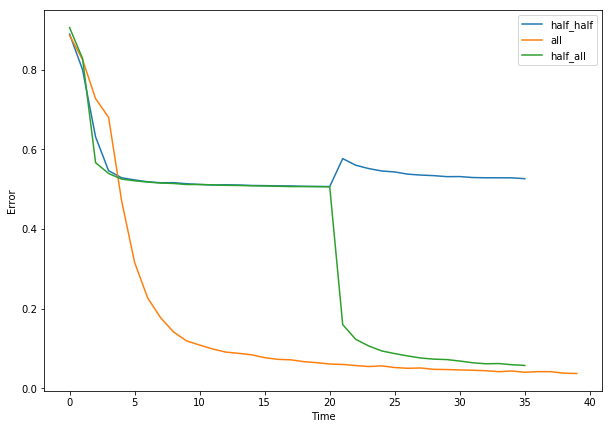

In [117]:
plt.figure(figsize = (10, 7))
plt.plot(1 - one_curve[('half_half')], label = 'half_half')
plt.plot(1 - one_curve[('all')], label = 'all')
plt.plot(1 - one_curve[('half_all')], label = 'half_all')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Error')

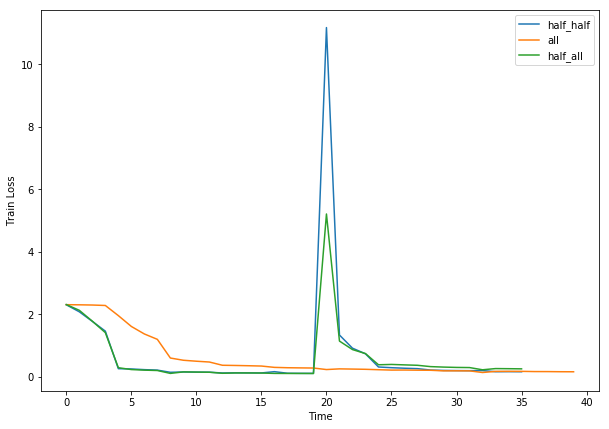

In [118]:
# 绘制训练集loss
one_curve = {}
for experiment in ['all', 'half_all', 'half_half']:
    one_experiment = []
    for time in range(times):
        rr = results[(experiment, time)]
        one_experiment.append([ii[0] for ii in rr[0]])
    aa = np.array(one_experiment)
    one_curve[(experiment)] = np.mean(aa, 0)
plt.figure(figsize = (10, 7))
plt.plot(one_curve[('half_half')], label = 'half_half')
plt.plot(one_curve[('all')], label = 'all')
plt.plot(one_curve[('half_all')], label = 'half_all')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Train Loss')

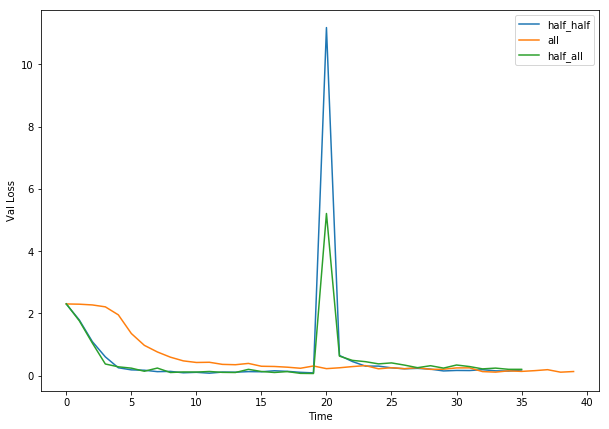

In [119]:
# 绘制校验集loss
one_curve = {}
for experiment in ['all', 'half_all', 'half_half']:
    one_experiment = []
    for time in range(times):
        rr = results[(experiment, time)]
        one_experiment.append([ii[1] for ii in rr[0]])
    aa = np.array(one_experiment)
    one_curve[(experiment)] = np.mean(aa, 0)
plt.figure(figsize = (10, 7))
plt.plot(one_curve[('half_half')], label = 'half_half')
plt.plot(one_curve[('all')], label = 'all')
plt.plot(one_curve[('half_all')], label = 'half_all')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Val Loss')

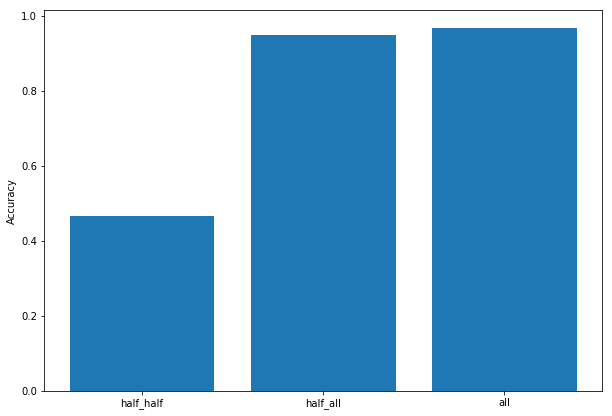

In [129]:
# 绘制三种情况下测试集下准确率柱状图
accuracy = []
labels = ['half_half', 'half_all', 'all']
for experiment in labels:
    accuracy.append(tests[experiment])
plt.figure(figsize = (10, 7))
plt.bar(range(len(accuracy)), accuracy, tick_label=labels)
plt.ylabel('Accuracy')

## 结论
1. 采用 0-4 训练后，此时采用 0-9 训练校验集错误率下降比直接用 0-9 训练要快，但测试集准确率要小于直接用 0-9 在整个epoch训练
2. 采用 0-4 训练后，采用 5-9 训练的得到的网络分类准确率只有不到一半